# Parse log file to obtain trading data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
log_file = 'log/round2_empty.log'

with open(log_file, 'r') as f:
    lines = f.readlines()
    
    activity_start = 0
    while not lines[activity_start].startswith('Activities log:'):
        activity_start += 1
    activity_start += 1
    activity_end = activity_start + 1
    while lines[activity_end] != '\n':
        activity_end += 1

    trade_start = activity_end + 1
    while not lines[trade_start].startswith('Trade History:'):
        trade_start += 1
    trade_start += 1
    trade_end = len(lines)

    trade_history = ''.join(lines[trade_start:trade_end])

activity_start, activity_end, trade_start, trade_end

(5005, 8006, 8011, 12630)

In [3]:
path = '../../shared_data/round2/prices_round_2_day_1.csv'

foreign_ORC = pd.read_csv(path, sep=';').set_index(['timestamp'])[:1000]
foreign_ORC

,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY
timestamp,,,,,,,
0,1098.25,0.9,10.5,-5.0,2100.0000,70.000000,1
100,1098.25,0.9,9.5,-5.0,2099.7570,70.022710,1
200,1096.75,0.9,9.5,-5.0,2099.5132,70.045395,1
300,1097.00,0.9,9.5,-5.0,2099.2683,70.068030,1
400,1097.25,0.9,9.5,-5.0,2099.0225,70.090640,1
...,...,...,...,...,...,...,...
99500,1070.75,1.1,8.5,-5.5,1701.2242,84.906700,1
99600,1071.75,1.1,8.5,-5.5,1700.9775,84.925300,1
99700,1072.00,1.1,8.5,-5.5,1700.7317,84.943930,1


In [4]:
activity_log = pd.read_csv(log_file, skiprows=activity_start, nrows=activity_end-activity_start-1, sep=';')
trade_history = pd.read_json(trade_history)
market_trades = trade_history[(trade_history.buyer == '') & (trade_history.seller == '')]
own_trades = trade_history[(trade_history.buyer == 'SUBMISSION') | (trade_history.seller == 'SUBMISSION')]

C:\Users\Meilism\AppData\Local\Temp\ipykernel_27440\972667722.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


# Visualize market trades and own trades

In [5]:
products = market_trades.symbol.unique()
products

array(['AMETHYSTS', 'STARFRUIT', 'ORCHIDS'], dtype=object)

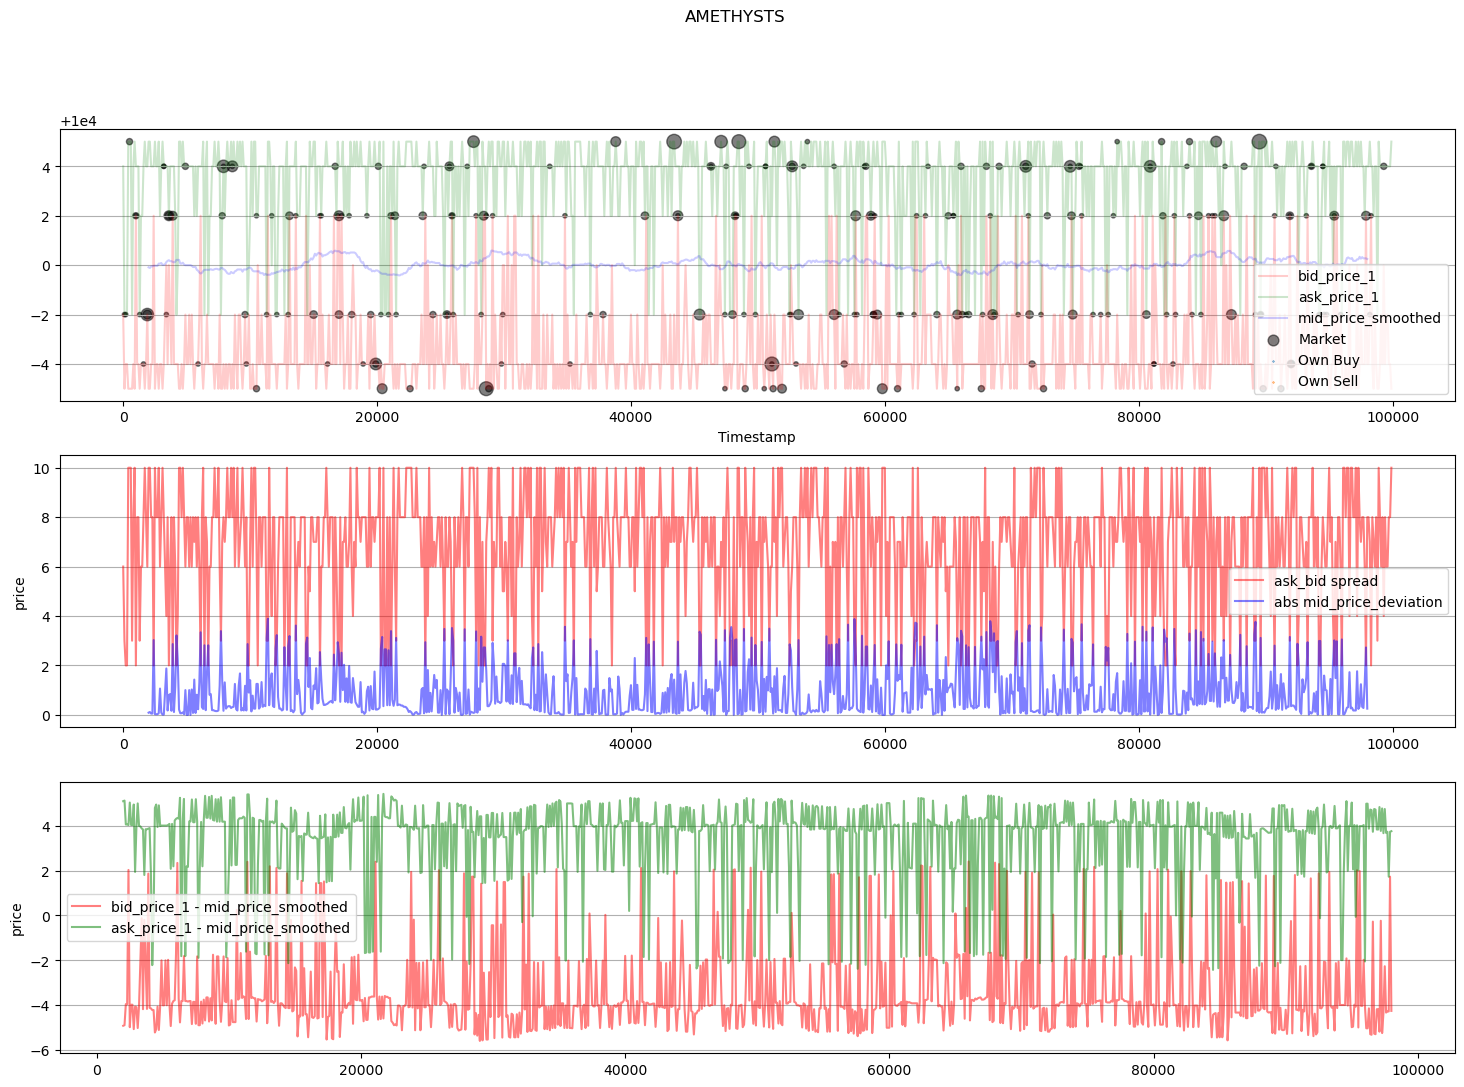

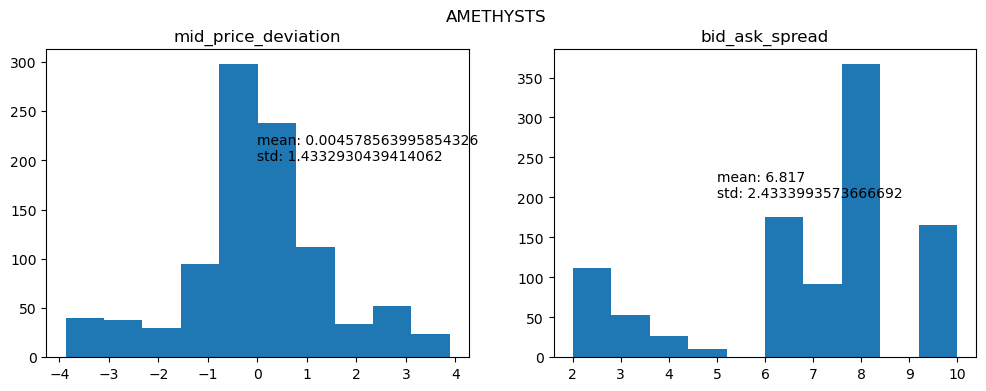

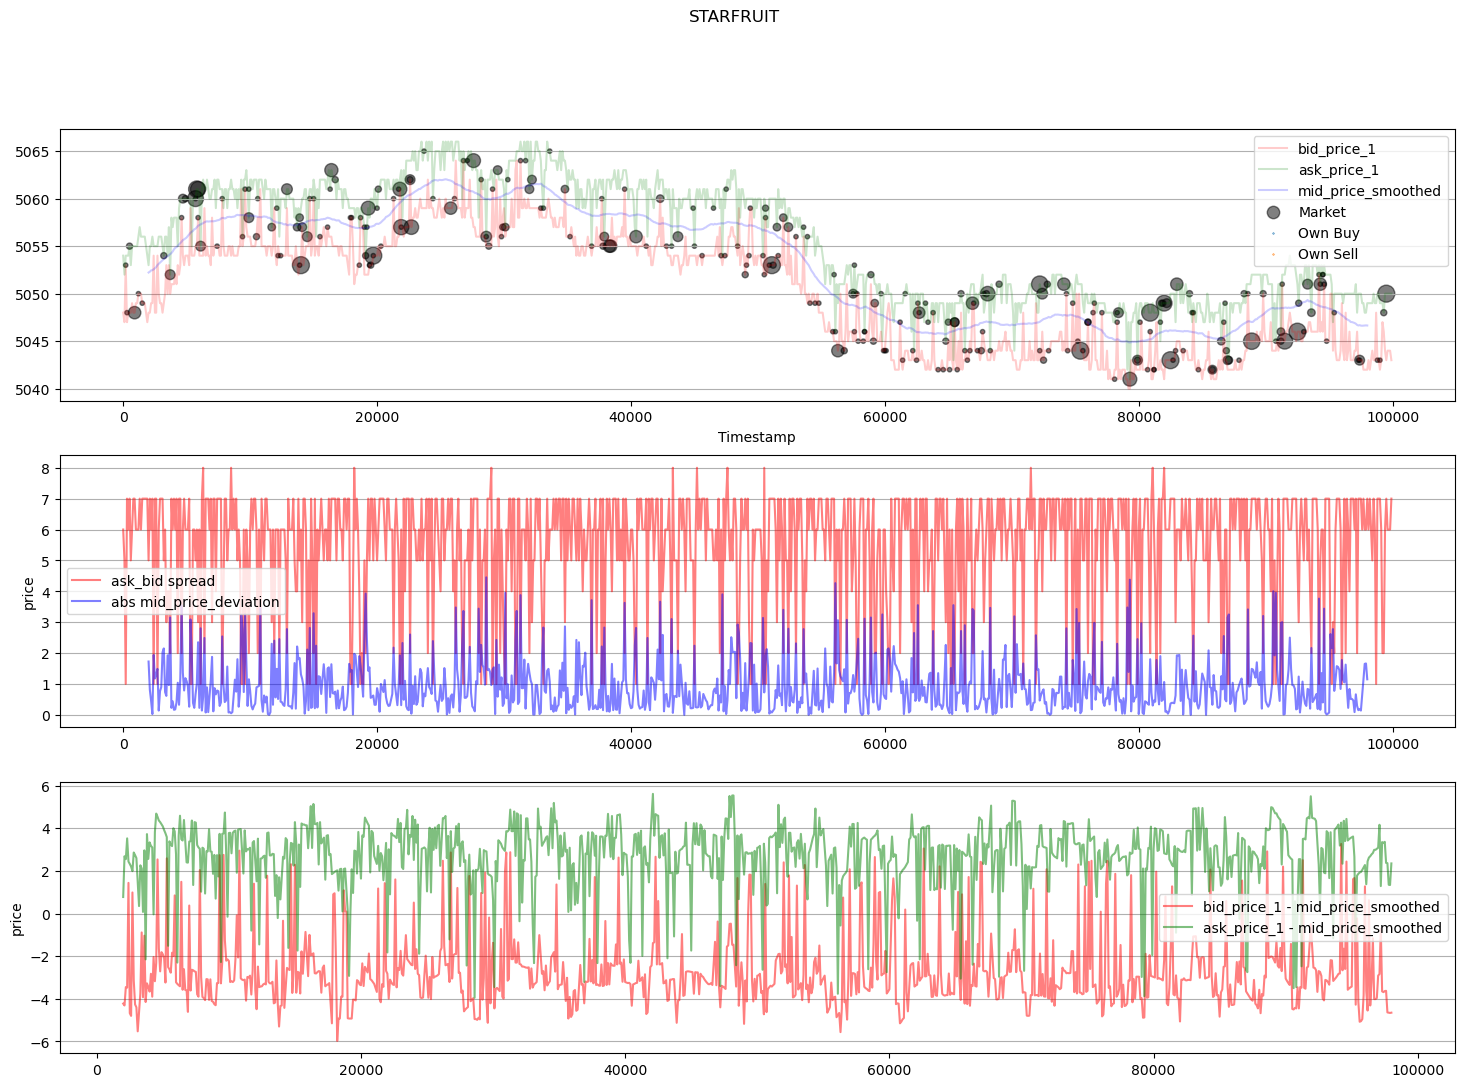

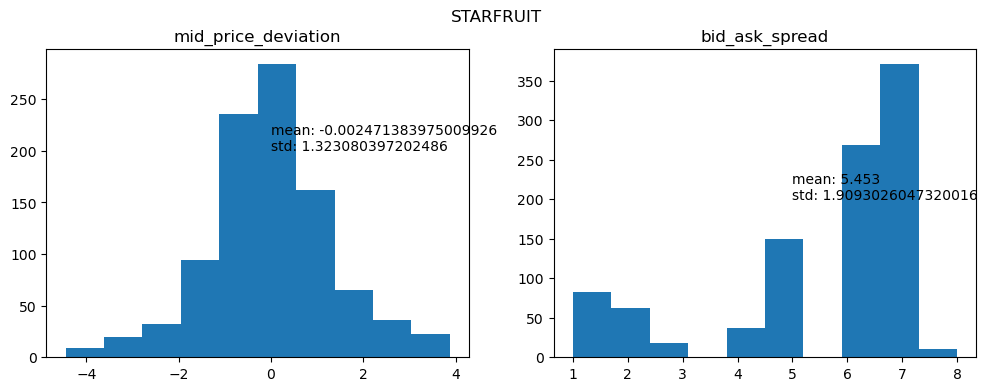

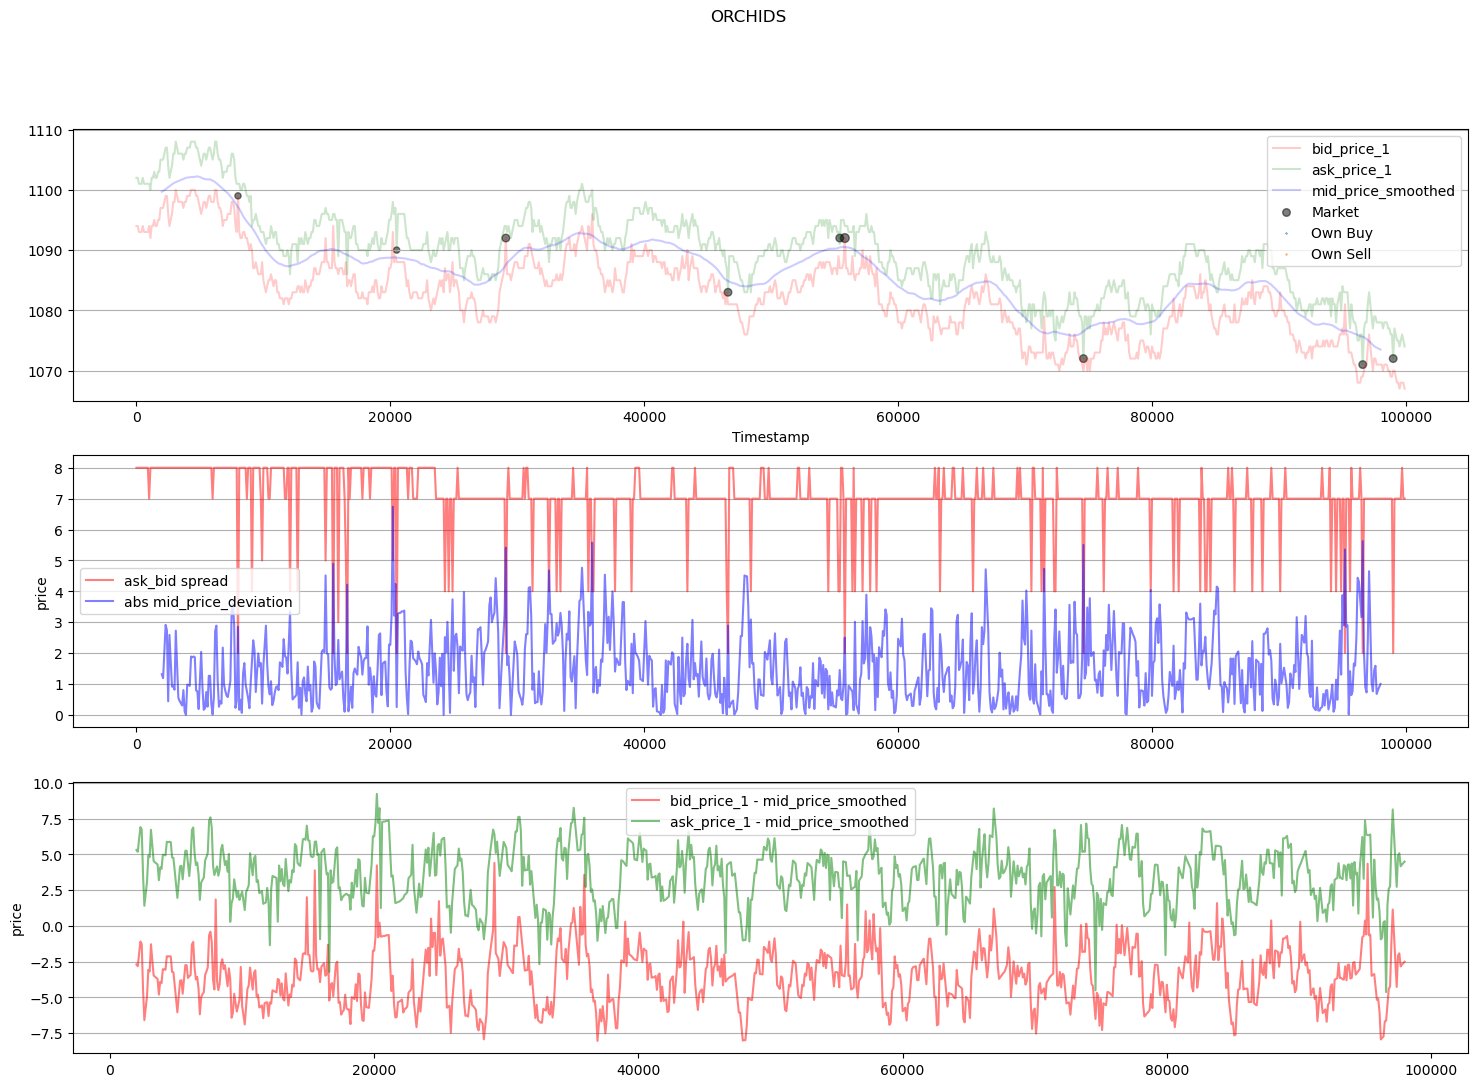

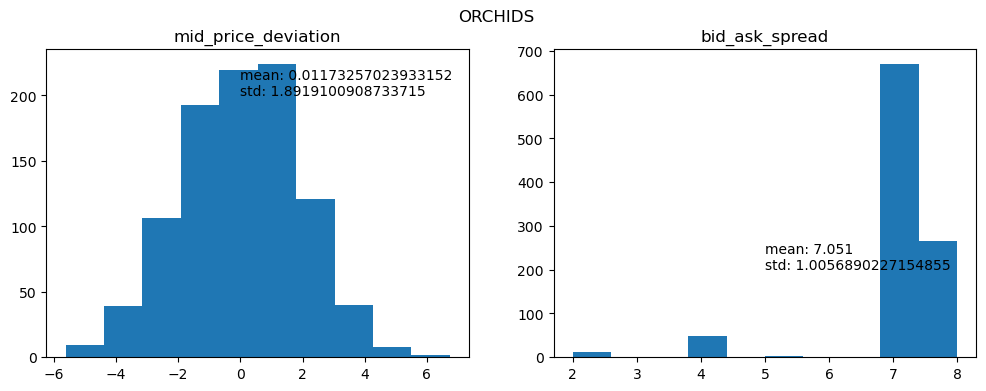

In [46]:
window_size = 40

for symbol in products:
    activity = activity_log[activity_log['product'] == symbol].set_index('timestamp')
    market = market_trades[market_trades.symbol == symbol].set_index('timestamp')

    assert isinstance(activity, pd.DataFrame)
    activity['mid_price_smoothed'] = activity['mid_price'].rolling(window=window_size, center=True).mean()
    activity['mid_price_deviation'] = activity['mid_price'] - activity['mid_price_smoothed']
    activity['bid_ask_spread'] = activity['ask_price_1'] - activity['bid_price_1']

    own_buy = own_trades[(own_trades.symbol == symbol) & (own_trades.buyer == 'SUBMISSION')].set_index('timestamp')
    own_sell = own_trades[(own_trades.symbol == symbol) & (own_trades.seller == 'SUBMISSION')].set_index('timestamp')
    
    fig, ax = plt.subplots(3, 1, figsize=(18, 12))
    fig.suptitle(symbol)

    plt.subplot(3, 1, 1)
    plt.plot(activity['bid_price_1'], label='bid_price_1', color='red', alpha=0.2,)
    plt.plot(activity['ask_price_1'], label='ask_price_1', color='green', alpha=0.2)
    plt.plot(activity['mid_price_smoothed'], label='mid_price_smoothed', color='blue', alpha=0.2)
    plt.scatter(market.index, market.price, label='Market', s=10*market.quantity, color='black', alpha=0.5)
    plt.scatter(own_buy.index, own_buy.price, label='Own Buy', s=10*own_buy.quantity, marker='x', alpha=0.5)
    plt.scatter(own_sell.index, own_sell.price, label='Own Sell', s=10*own_sell.quantity, marker='x', alpha=0.5)
    plt.xlabel('Timestamp')
    plt.grid(axis='y')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(activity['ask_price_1'] - activity['bid_price_1'], label='ask_bid spread', color='red', alpha=0.5)
    plt.plot(abs(activity['mid_price_deviation']), label='abs mid_price_deviation', color='blue', alpha=0.5)
    plt.ylabel('price')
    plt.grid(axis='y')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(activity['bid_price_1'] - activity['mid_price_smoothed'], label='bid_price_1 - mid_price_smoothed', color='red', alpha=0.5)
    plt.plot(activity['ask_price_1'] - activity['mid_price_smoothed'], label='ask_price_1 - mid_price_smoothed', color='green', alpha=0.5)
    plt.ylabel('price')
    plt.grid(axis='y')
    plt.legend()
    
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(symbol)

    plt.subplot(1, 2, 1)
    plt.hist(activity['mid_price_deviation'], label='mid_price_deviation')
    plt.text(0, 200, f"mean: {activity['mid_price_deviation'].mean()}\nstd: {activity['mid_price_deviation'].std()}")
    plt.title('mid_price_deviation')

    plt.subplot(1, 2, 2)
    plt.hist(activity['bid_ask_spread'], label='bid_ask_spread')
    plt.text(5, 200, f"mean: {activity['bid_ask_spread'].mean()}\nstd: {activity['bid_ask_spread'].std()}")
    plt.title('bid_ask_spread')
    
    plt.show()

# Statistics of products (look at only market trades)

## AMETHYSTS

In [7]:
market = market_trades[market_trades.symbol == 'AMETHYSTS']
market.value_counts('price').sort_index()

price
9995     17
9996     19
9998     73
10002    64
10004    47
10005    13
Name: count, dtype: int64

In [8]:
market.price.describe()

count      233.000000
mean     10000.317597
std          3.169424
min       9995.000000
25%       9998.000000
50%      10002.000000
75%      10004.000000
max      10005.000000
Name: price, dtype: float64

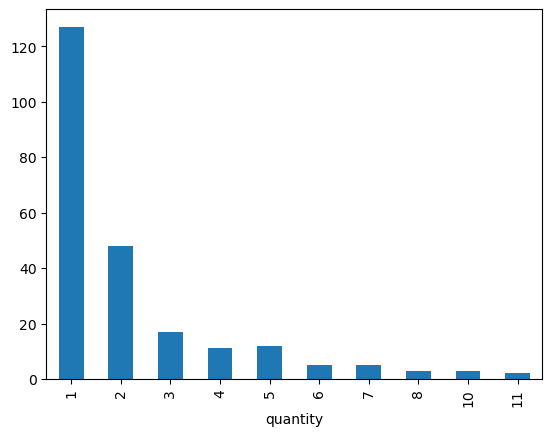

In [9]:
market.value_counts('quantity').sort_index().plot(kind='bar')
plt.show()

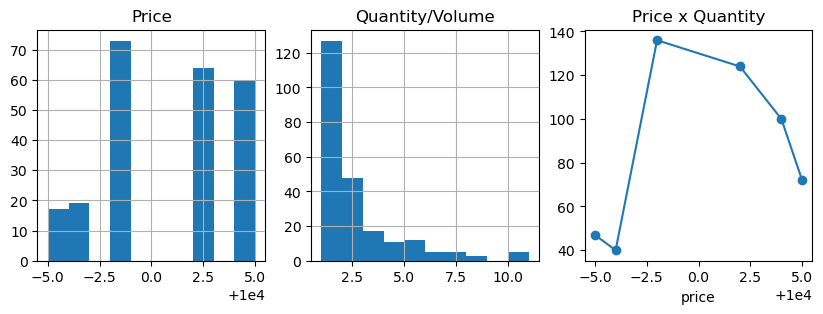

In [10]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
market.price.hist()
plt.title('Price')

plt.subplot(1, 3, 2)
market.quantity.hist()
plt.title('Quantity/Volume')

plt.subplot(1, 3, 3)
market.groupby('price').quantity.sum().plot(marker='o')
plt.title('Price x Quantity')

plt.show()

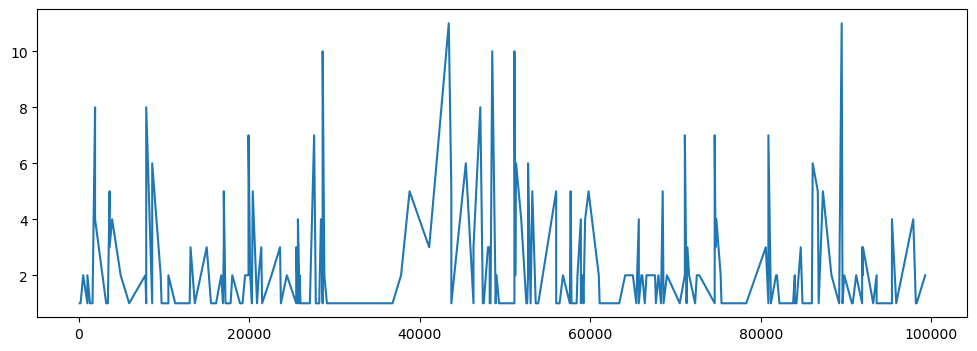

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(market.timestamp, market.quantity)
plt.show()

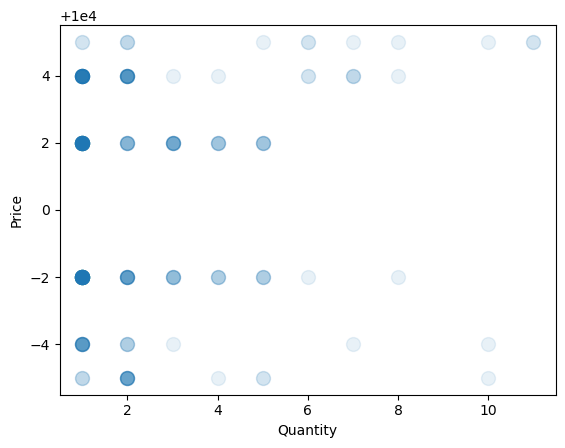

In [12]:
plt.scatter(market.quantity, market.price, alpha=0.1, s=100)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

## STARFRUIT


In [13]:
market = market_trades[market_trades.symbol == 'STARFRUTIT']

## ORCHIDS

In [14]:
market = market_trades[market_trades.symbol == 'ORCHIDS']
market.value_counts('price').sort_index()

price
1071    1
1072    2
1083    1
1090    1
1092    3
1099    1
Name: count, dtype: int64

# Price activity

## AMETHYSTS

## STARFRUIT

## ORCHIDS

In [15]:
activity_ORC = activity_log[activity_log['product'] == 'ORCHIDS'].set_index(['timestamp'])
foreign_ORC['BUY_PRICE'] = foreign_ORC['ORCHIDS'] + foreign_ORC['IMPORT_TARIFF'] + foreign_ORC['TRANSPORT_FEES'] + 0.75
foreign_ORC['SELL_PRICE'] = foreign_ORC['ORCHIDS'] + foreign_ORC['EXPORT_TARIFF'] + foreign_ORC['TRANSPORT_FEES'] - 0.75

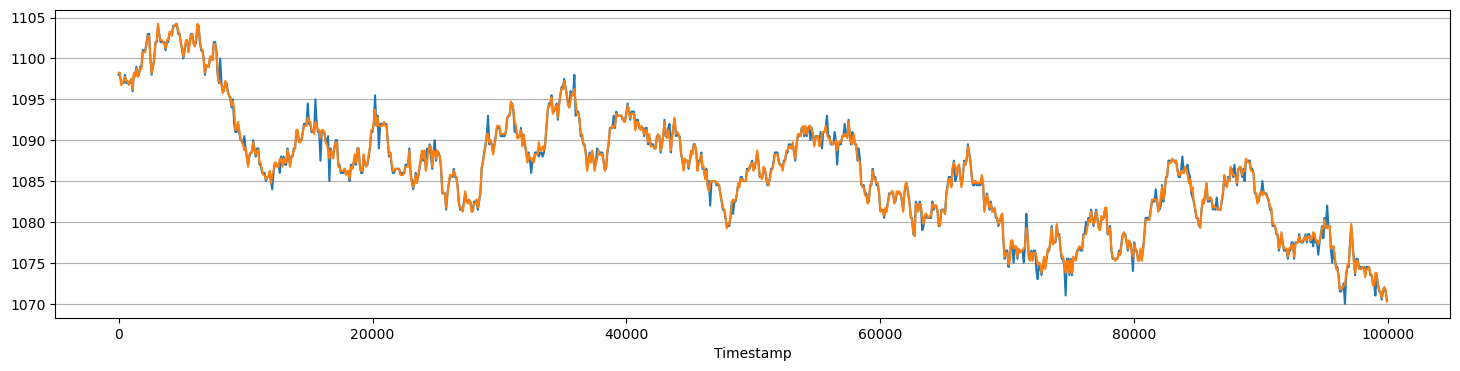

In [16]:
fig, ax = plt.subplots(figsize=(18, 4))
plt.plot(activity_ORC['mid_price'], label='mid_price (local)')
plt.plot(foreign_ORC['ORCHIDS'], label='mid_price (foreign)')
plt.xlabel('Timestamp')
plt.grid(axis='y')
plt.show()

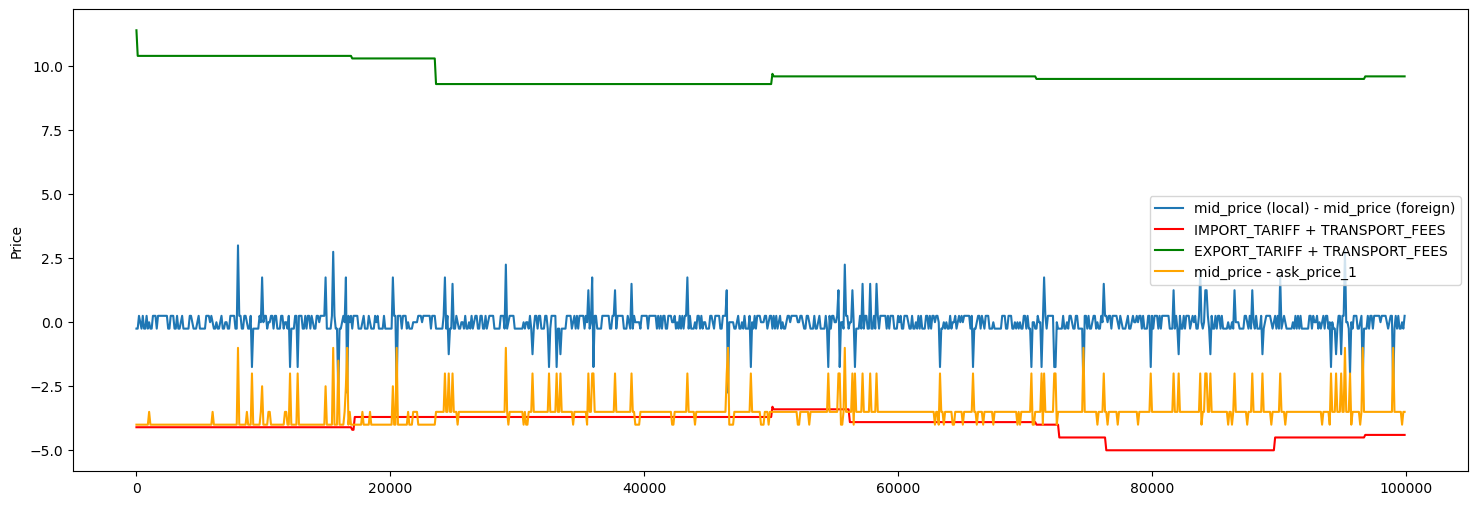

In [19]:
diff = activity_ORC['mid_price'] - foreign_ORC['ORCHIDS']

fig, ax = plt.subplots(figsize=(18, 6))
assert isinstance(ax, plt.Axes)

ax.plot(diff, label='mid_price (local) - mid_price (foreign)')
ax.plot(foreign_ORC['IMPORT_TARIFF'] + foreign_ORC['TRANSPORT_FEES'], color='red', label='IMPORT_TARIFF + TRANSPORT_FEES')
ax.plot(foreign_ORC['EXPORT_TARIFF'] + foreign_ORC['TRANSPORT_FEES'], color='green', label='EXPORT_TARIFF + TRANSPORT_FEES')
ax.plot(activity_ORC['bid_price_1'] - activity_ORC['mid_price'], color='orange', label='mid_price - ask_price_1')
ax.legend()
ax.set_ylabel('Price')
plt.show()

In [45]:
diff.describe()

count    1000.000000
mean       -0.012250
std         0.515804
min        -2.750000
25%        -0.250000
50%         0.000000
75%         0.250000
max         3.000000
dtype: float64

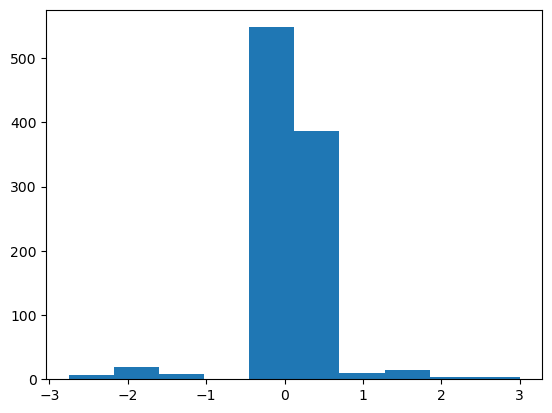

In [21]:
plt.figure()
plt.hist(diff)
plt.show()

In [22]:
diff.value_counts().sort_index()

-2.75      6
-2.25      1
-2.00      1
-1.75     18
-1.25      8
-0.25    396
 0.00    152
 0.25    387
 1.25     10
 1.50      6
 1.75      9
 2.00      1
 2.25      2
 2.75      2
 3.00      1
Name: count, dtype: int64

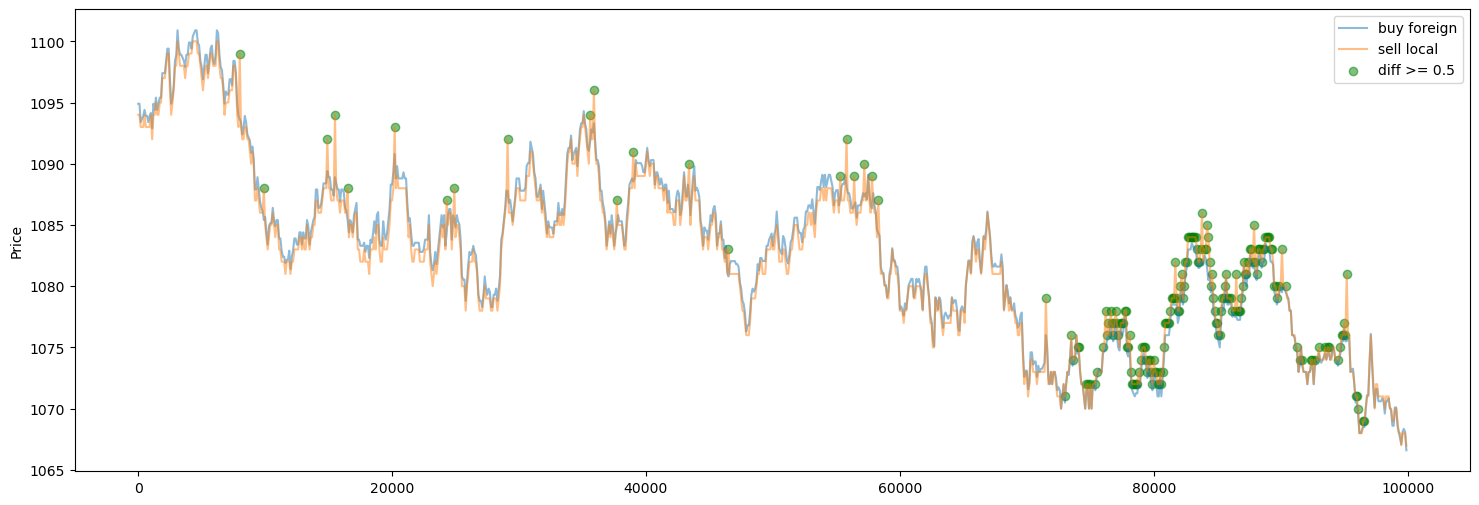

In [37]:
diff2 = activity_ORC['bid_price_1'] - foreign_ORC['BUY_PRICE']
mask = diff2 >= 0.5

fig, ax = plt.subplots(figsize=(18, 6))
assert isinstance(ax, plt.Axes)

ax.plot(foreign_ORC['BUY_PRICE'], label='buy foreign', alpha=0.5)
ax.plot(activity_ORC['bid_price_1'], label='sell local', alpha=0.5)
ax.scatter(diff.index[mask], activity_ORC['bid_price_1'][mask], color='green', label='diff >= 0.5', alpha=0.5)
ax.legend()
ax.set_ylabel('Price')
# ax2.plot(activity_ORC['bid_price_1'] - foreign_ORC['BUY_PRICE'], color='red', label='diff', alpha=0.5)
# ax2.hlines(0, activity_ORC.index[0], activity_ORC.index[-1], color='black', alpha=0.5)
# ax2.set_ylabel('Difference')
plt.show()

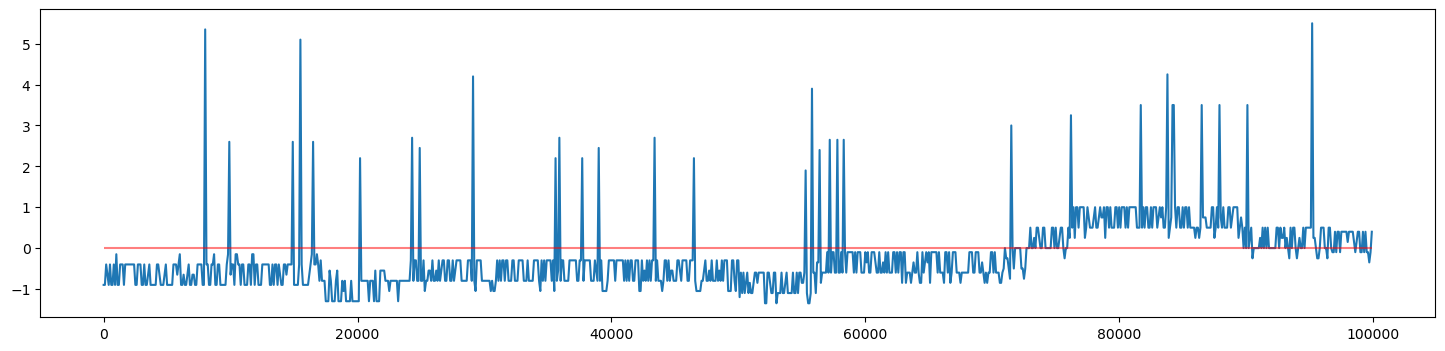

In [44]:
plt.figure(figsize=(18, 4))
plt.plot(diff2)
plt.hlines(0, diff2.index[0], diff2.index[-1], color='red', alpha=0.5)
plt.title('sell_')
plt.show()

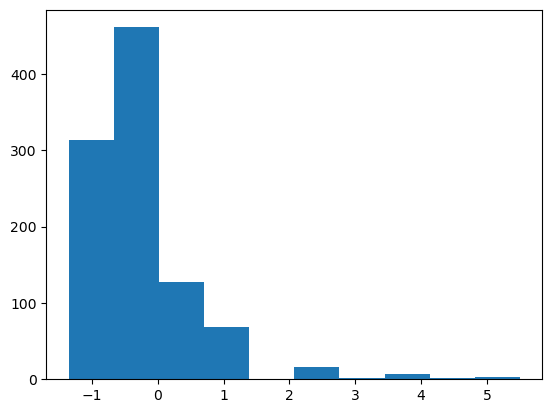

In [49]:
plt.figure()
plt.hist(diff2)
plt.show()

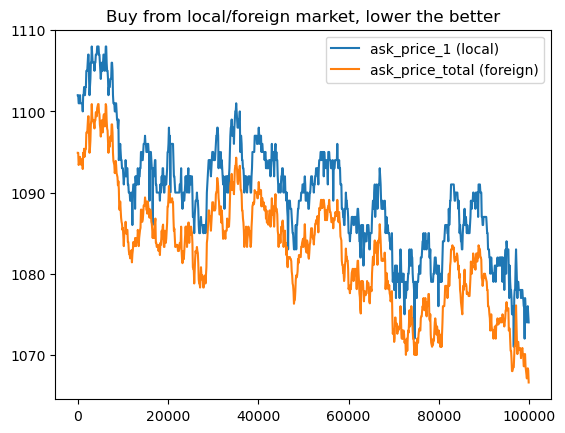

In [57]:
plt.plot(activity_ORC['ask_price_1'], label='ask_price_1 (local)')
plt.plot(foreign_ORC['BUY_PRICE'], label='ask_price_total (foreign)')
plt.legend()
plt.title('Buy from local/foreign market, lower the better')
plt.show()

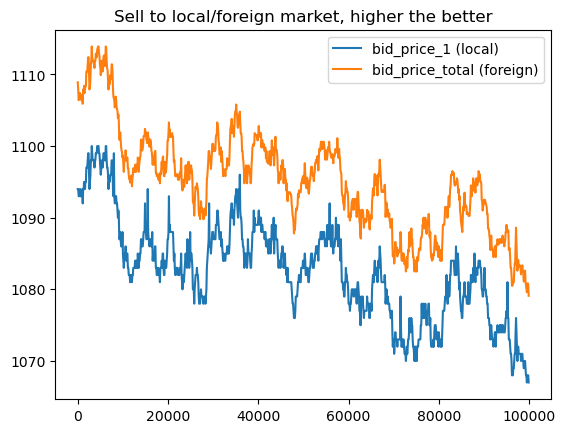

In [58]:
plt.plot(activity_ORC['bid_price_1'], label='bid_price_1 (local)')
plt.plot(foreign_ORC['SELL_PRICE'], label='bid_price_total (foreign)')
plt.legend()
plt.title('Sell to local/foreign market, higher the better')
plt.show()